In [1]:
#!unzip leapGestRecog.zip

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from datetime import datetime

In [3]:
# Parameters
BATCH_SIZE = 64
RESIZE = 32
EPOCHS = 10
MODEL = models.resnet50
OUR_TOPOLOGY = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
OPTIMIZER = optim.Adam
OPTIMIZER_PARAMETERS = {"lr": 0.003}

In [4]:
transform = transforms.Compose([transforms.Resize(RESIZE),
                                transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

alldataset = torchvision.datasets.ImageFolder(root='./leapGestRecog/00', transform=transform)

for i in range(1, 10):
    folder = torchvision.datasets.ImageFolder(root='./leapGestRecog/0{}'.format(i), transform=transform)
    alldataset = torch.utils.data.ConcatDataset([alldataset, folder])
    
num_train = len(alldataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, test_idx = indices[split:], indices[:split]
train_idx, valid_idx = train_idx[split:], train_idx[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    alldataset, batch_size=BATCH_SIZE, sampler=train_sampler,
    num_workers=12
)
validloader = torch.utils.data.DataLoader(
    alldataset, batch_size=BATCH_SIZE, sampler=valid_sampler,
    num_workers=12
)
testloader = torch.utils.data.DataLoader(
    alldataset, batch_size=BATCH_SIZE, sampler=test_sampler,
    num_workers=12
)

classes = ('01_palm', '02_l', '03_fist', '04_fist_moved',
           '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down')

In [5]:
print(len(trainloader), len(validloader), len(testloader))

250 32 32


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

<Figure size 640x480 with 1 Axes>

01_palm 03_fist  02_l 08_palm_moved  09_c  02_l 06_index 07_ok  02_l 06_index  02_l 10_down 03_fist 04_fist_moved 03_fist 05_thumb 05_thumb 04_fist_moved  09_c 10_down 03_fist  02_l 08_palm_moved 04_fist_moved 07_ok 04_fist_moved  02_l  09_c 06_index  02_l 04_fist_moved  02_l 05_thumb 03_fist 07_ok  02_l  09_c 08_palm_moved 08_palm_moved  09_c 10_down 05_thumb 08_palm_moved 03_fist 08_palm_moved 05_thumb 05_thumb 07_ok 05_thumb 01_palm  09_c  09_c 04_fist_moved 10_down 04_fist_moved  02_l 08_palm_moved 10_down  02_l 08_palm_moved 07_ok 05_thumb  02_l  02_l


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:

model = MODEL(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = OUR_TOPOLOGY
criterion = nn.NLLLoss()
optimizer = OPTIMIZER(model.parameters(), **OPTIMIZER_PARAMETERS)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
epochs = EPOCHS
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

t1 = datetime.now()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()
t2 = datetime.now()

Epoch 1/10.. Train loss: 2.665.. Test loss: 2.116.. Test accuracy: 0.244
Epoch 1/10.. Train loss: 1.284.. Test loss: 1.773.. Test accuracy: 0.393
Epoch 1/10.. Train loss: 0.940.. Test loss: 1.539.. Test accuracy: 0.495
Epoch 1/10.. Train loss: 0.736.. Test loss: 1.732.. Test accuracy: 0.457
Epoch 1/10.. Train loss: 0.600.. Test loss: 1.872.. Test accuracy: 0.467
Epoch 1/10.. Train loss: 0.565.. Test loss: 1.849.. Test accuracy: 0.472
Epoch 1/10.. Train loss: 0.535.. Test loss: 1.498.. Test accuracy: 0.606
Epoch 1/10.. Train loss: 0.443.. Test loss: 0.772.. Test accuracy: 0.799
Epoch 1/10.. Train loss: 0.408.. Test loss: 0.299.. Test accuracy: 0.912
Epoch 1/10.. Train loss: 0.379.. Test loss: 0.293.. Test accuracy: 0.908
Epoch 1/10.. Train loss: 0.366.. Test loss: 0.249.. Test accuracy: 0.930
Epoch 1/10.. Train loss: 0.337.. Test loss: 0.211.. Test accuracy: 0.942
Epoch 1/10.. Train loss: 0.333.. Test loss: 0.154.. Test accuracy: 0.965
Epoch 1/10.. Train loss: 0.315.. Test loss: 0.147..

Epoch 5/10.. Train loss: 0.096.. Test loss: 0.034.. Test accuracy: 0.992
Epoch 5/10.. Train loss: 0.080.. Test loss: 0.032.. Test accuracy: 0.992
Epoch 5/10.. Train loss: 0.044.. Test loss: 0.032.. Test accuracy: 0.992
Epoch 5/10.. Train loss: 0.080.. Test loss: 0.045.. Test accuracy: 0.988
Epoch 5/10.. Train loss: 0.112.. Test loss: 0.042.. Test accuracy: 0.990
Epoch 5/10.. Train loss: 0.113.. Test loss: 0.046.. Test accuracy: 0.988
Epoch 5/10.. Train loss: 0.098.. Test loss: 0.056.. Test accuracy: 0.987
Epoch 5/10.. Train loss: 0.071.. Test loss: 0.034.. Test accuracy: 0.991
Epoch 5/10.. Train loss: 0.039.. Test loss: 0.041.. Test accuracy: 0.990
Epoch 5/10.. Train loss: 0.054.. Test loss: 0.049.. Test accuracy: 0.989
Epoch 5/10.. Train loss: 0.087.. Test loss: 0.039.. Test accuracy: 0.991
Epoch 5/10.. Train loss: 0.072.. Test loss: 0.031.. Test accuracy: 0.993
Epoch 6/10.. Train loss: 0.037.. Test loss: 0.042.. Test accuracy: 0.988
Epoch 6/10.. Train loss: 0.058.. Test loss: 0.033..

Epoch 10/10.. Train loss: 0.083.. Test loss: 0.030.. Test accuracy: 0.994
Epoch 10/10.. Train loss: 0.061.. Test loss: 0.033.. Test accuracy: 0.995
Epoch 10/10.. Train loss: 0.085.. Test loss: 0.034.. Test accuracy: 0.993
Epoch 10/10.. Train loss: 0.068.. Test loss: 0.036.. Test accuracy: 0.993
Epoch 10/10.. Train loss: 0.058.. Test loss: 0.030.. Test accuracy: 0.992
Epoch 10/10.. Train loss: 0.020.. Test loss: 0.032.. Test accuracy: 0.995
Epoch 10/10.. Train loss: 0.039.. Test loss: 0.031.. Test accuracy: 0.995
Epoch 10/10.. Train loss: 0.053.. Test loss: 0.042.. Test accuracy: 0.992
Epoch 10/10.. Train loss: 0.028.. Test loss: 0.033.. Test accuracy: 0.990
Epoch 10/10.. Train loss: 0.067.. Test loss: 0.042.. Test accuracy: 0.993
Epoch 10/10.. Train loss: 0.061.. Test loss: 0.040.. Test accuracy: 0.993
Epoch 10/10.. Train loss: 0.074.. Test loss: 0.034.. Test accuracy: 0.994
Epoch 10/10.. Train loss: 0.072.. Test loss: 0.029.. Test accuracy: 0.995
Epoch 10/10.. Train loss: 0.055.. Test

Start time: 2019-10-01 22:13:57.895647
Finishing time: 2019-10-01 22:19:00.759385


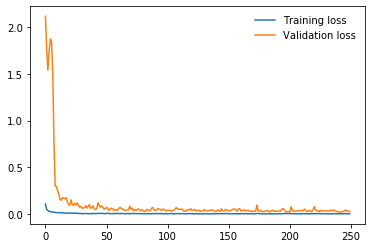

93.859375


In [14]:
print("Start time: {}".format(t1))
print("Finishing time: {}".format(t2))

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(accuracy)